In [1]:
#Import XGBoost for Gradient Boosted Trees and SciKit-Learn + Pandas for metrics and dataset preprocessing
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

c:\Users\mindf\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#Import datasets and concatenate
#Set na_filter to False to prevent pandas from interpreting NA as NaN values
COMPLETE_DATASET = pd.read_csv(r'HOUSING PRICES DATASET/train.csv', na_filter = False)
# TEST_DATASET = pd.read_csv(r'HOUSING PRICES DATASET/test.csv', na_filter = False)
# COMPLETE_DATASET = pd.concat([TRAIN_DATASET, TEST_DATASET])
COMPLETE_DATASET.head()
print(type(COMPLETE_DATASET))
print(COMPLETE_DATASET._get_numeric_data().columns)
print(COMPLETE_DATASET["LotFrontage"])

<class 'pandas.core.frame.DataFrame'>
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
0       65
1       80
2       68
3       60
4       84
        ..
1196    62
1197    85
1198    66
1199    68
1200    75
Name: LotFrontage, Length: 1201, dtype: int64


In [3]:
print(COMPLETE_DATASET["BsmtExposure"])
print(COMPLETE_DATASET["BsmtExposure"].isnull().any())
COMPLETE_DATASET[COMPLETE_DATASET.isnull().any(axis = 1)]

0       No
1       Gd
2       Mn
3       No
4       Av
        ..
1196    No
1197    No
1198    No
1199    Mn
1200    No
Name: BsmtExposure, Length: 1201, dtype: object
False


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [4]:
#Preprocess input data - all non-continuous columns must be ordinal encoded
#Similarly, all continuous columns must be normalized between 0 and 1 (to avoid exploding gradients)
from sklearn import preprocessing
normalizer = preprocessing.LabelEncoder()
ordinal_encoder = preprocessing.OrdinalEncoder()
#Get all categorical and continuous columns
NONCATEGORICAL_COLUMNS = list(COMPLETE_DATASET._get_numeric_data().columns[1:-1])
CATEGORICAL_COLUMNS = list(set(COMPLETE_DATASET.columns) - set(NONCATEGORICAL_COLUMNS))
print(CATEGORICAL_COLUMNS)
CATEGORICAL_COLUMNS.remove("Id")
CATEGORICAL_COLUMNS.remove("SalePrice")
# print(NONCATEGORICAL_COLUMNS)
print(CATEGORICAL_COLUMNS)
#Normalize all noncategorical columns
for column in NONCATEGORICAL_COLUMNS:
    # COMPLETE_DATASET.head()
    # print(COMPLETE_DATASET[column])
    COMPLETE_DATASET[column] = pd.DataFrame(normalizer.fit(COMPLETE_DATASET[column]).transform(COMPLETE_DATASET[column]))
#Ordinal Encode all categorical columns
for column in CATEGORICAL_COLUMNS:
    print(column)
    print('BEFORE: ')
    print(COMPLETE_DATASET[column])
    COMPLETE_DATASET[column]= pd.DataFrame(ordinal_encoder.fit(COMPLETE_DATASET[[column]]).transform(COMPLETE_DATASET[[column]]))
    print('AFTER: ')
    print(COMPLETE_DATASET[column])
print(COMPLETE_DATASET.head())

['LotConfig', 'BsmtFinType1', 'HeatingQC', 'Street', 'LotShape', 'GarageType', 'Exterior1st', 'Alley', 'MasVnrType', 'GarageCond', 'BsmtExposure', 'SaleCondition', 'SalePrice', 'CentralAir', 'PavedDrive', 'Functional', 'Id', 'RoofMatl', 'MSZoning', 'SaleType', 'GarageQual', 'BsmtQual', 'KitchenQual', 'GarageYrBlt', 'Electrical', 'Heating', 'HouseStyle', 'RoofStyle', 'Foundation', 'Utilities', 'Condition1', 'MiscFeature', 'GarageFinish', 'BsmtCond', 'LandContour', 'MasVnrArea', 'BsmtFinType2', 'PoolQC', 'Condition2', 'Exterior2nd', 'Neighborhood', 'Fence', 'BldgType', 'ExterCond', 'FireplaceQu', 'ExterQual', 'LandSlope']
['LotConfig', 'BsmtFinType1', 'HeatingQC', 'Street', 'LotShape', 'GarageType', 'Exterior1st', 'Alley', 'MasVnrType', 'GarageCond', 'BsmtExposure', 'SaleCondition', 'CentralAir', 'PavedDrive', 'Functional', 'RoofMatl', 'MSZoning', 'SaleType', 'GarageQual', 'BsmtQual', 'KitchenQual', 'GarageYrBlt', 'Electrical', 'Heating', 'HouseStyle', 'RoofStyle', 'Foundation', 'Utiliti

In [5]:
#Identify X and Y data (input features and output regression feature) to allow for a complete train test split via SciKit-Learn
X_DATA = COMPLETE_DATASET.iloc[:, 1:80]
Y_DATA = COMPLETE_DATASET.iloc[:, 80]
#Split into training and testing data
TRAIN_X, VALID_X, TRAIN_Y, VALID_Y = train_test_split(X_DATA, Y_DATA, random_state = 100, shuffle = True)
#Get all feature names
feature_names = X_DATA.columns.values
print(feature_names)
#Convert to DMatrix (optimized matrix type for XGBoost Performance)
XGB_TRAIN = xgb.DMatrix(TRAIN_X, TRAIN_Y, feature_names = feature_names)
XGB_TEST = xgb.DMatrix(VALID_X, VALID_Y, feature_names = feature_names)

['MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 'MiscVal' 'MoSold' 'YrSold' 'SaleType' '

In [6]:
#Set parameters for XGBoost Model Training
HOUSING_REGRESSOR_PARAMS = {"booster" : "gbtree", "objective" : "reg:squarederror",
                            "max_depth" : 10, "learning_rate" : 0.01, "n_estimators" : 10, 
                            "subsample" : 0.1, "colsample_bytree" : 1}
#Begin model training (fit to training data)
HOUSING_REGRESSOR = xgb.train(HOUSING_REGRESSOR_PARAMS, XGB_TRAIN, evals = [(XGB_TRAIN, "TRAINING"),
                    (XGB_TEST, "TESTING")], num_boost_round = 500, early_stopping_rounds = 40)
#Predict on testing data and calculate root mean squared error
predicted_prices = HOUSING_REGRESSOR.predict(XGB_TEST)
print("PREDICTIONS:\n", predicted_prices[:10])
print("ACTUAL PRICES:\n", list(VALID_Y[:10]))
RMSE = np.sqrt(mean_squared_error(VALID_Y, predicted_prices))
print("ROOT MEAN SQUARED ERROR:", RMSE)

[12:40:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	TRAINING-rmse:199005.25000	TESTING-rmse:192256.07812
[1]	TRAINING-rmse:197290.37500	TESTING-rmse:190547.10938
[2]	TRAINING-rmse:195558.07812	TESTING-rmse:188799.59375
[3]	TRAINING-rmse:193958.81250	TESTING-rmse:187249.67188
[4]	TRAINING-rmse:192362.04688	TESTING-rmse:185605.92188
[5]	TRAINING-rmse:190760.56250	TESTING-rmse:183992.04688
[6]	TRAINING-rmse:189101.01562	TESTING-rmse:182302.32812
[7]	TRAINING-rmse:187612.96875	TESTING-rmse:180833.21875
[8]	TRAINING-rmse:185884.92188	TESTING-rmse:179106.29688
[9]	TRAINING-rmse:184214.39062	TESTING-rmse:17738

In [71]:
#Save model
HOUSING_REGRESSOR.save_model("HOUSING_REGRESSOR.model")

In [61]:
print(XGB_TEST)

In [13]:
#Load model
HOUSING_REGRESSOR = xgb.XGBRegressor(feature_names = feature_names)
HOUSING_REGRESSOR.load_model("HOUSING_REGRESSOR.model")

c:\Users\mindf\anaconda3\lib\site-packages\xgboost\sklearn.py:604: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn(


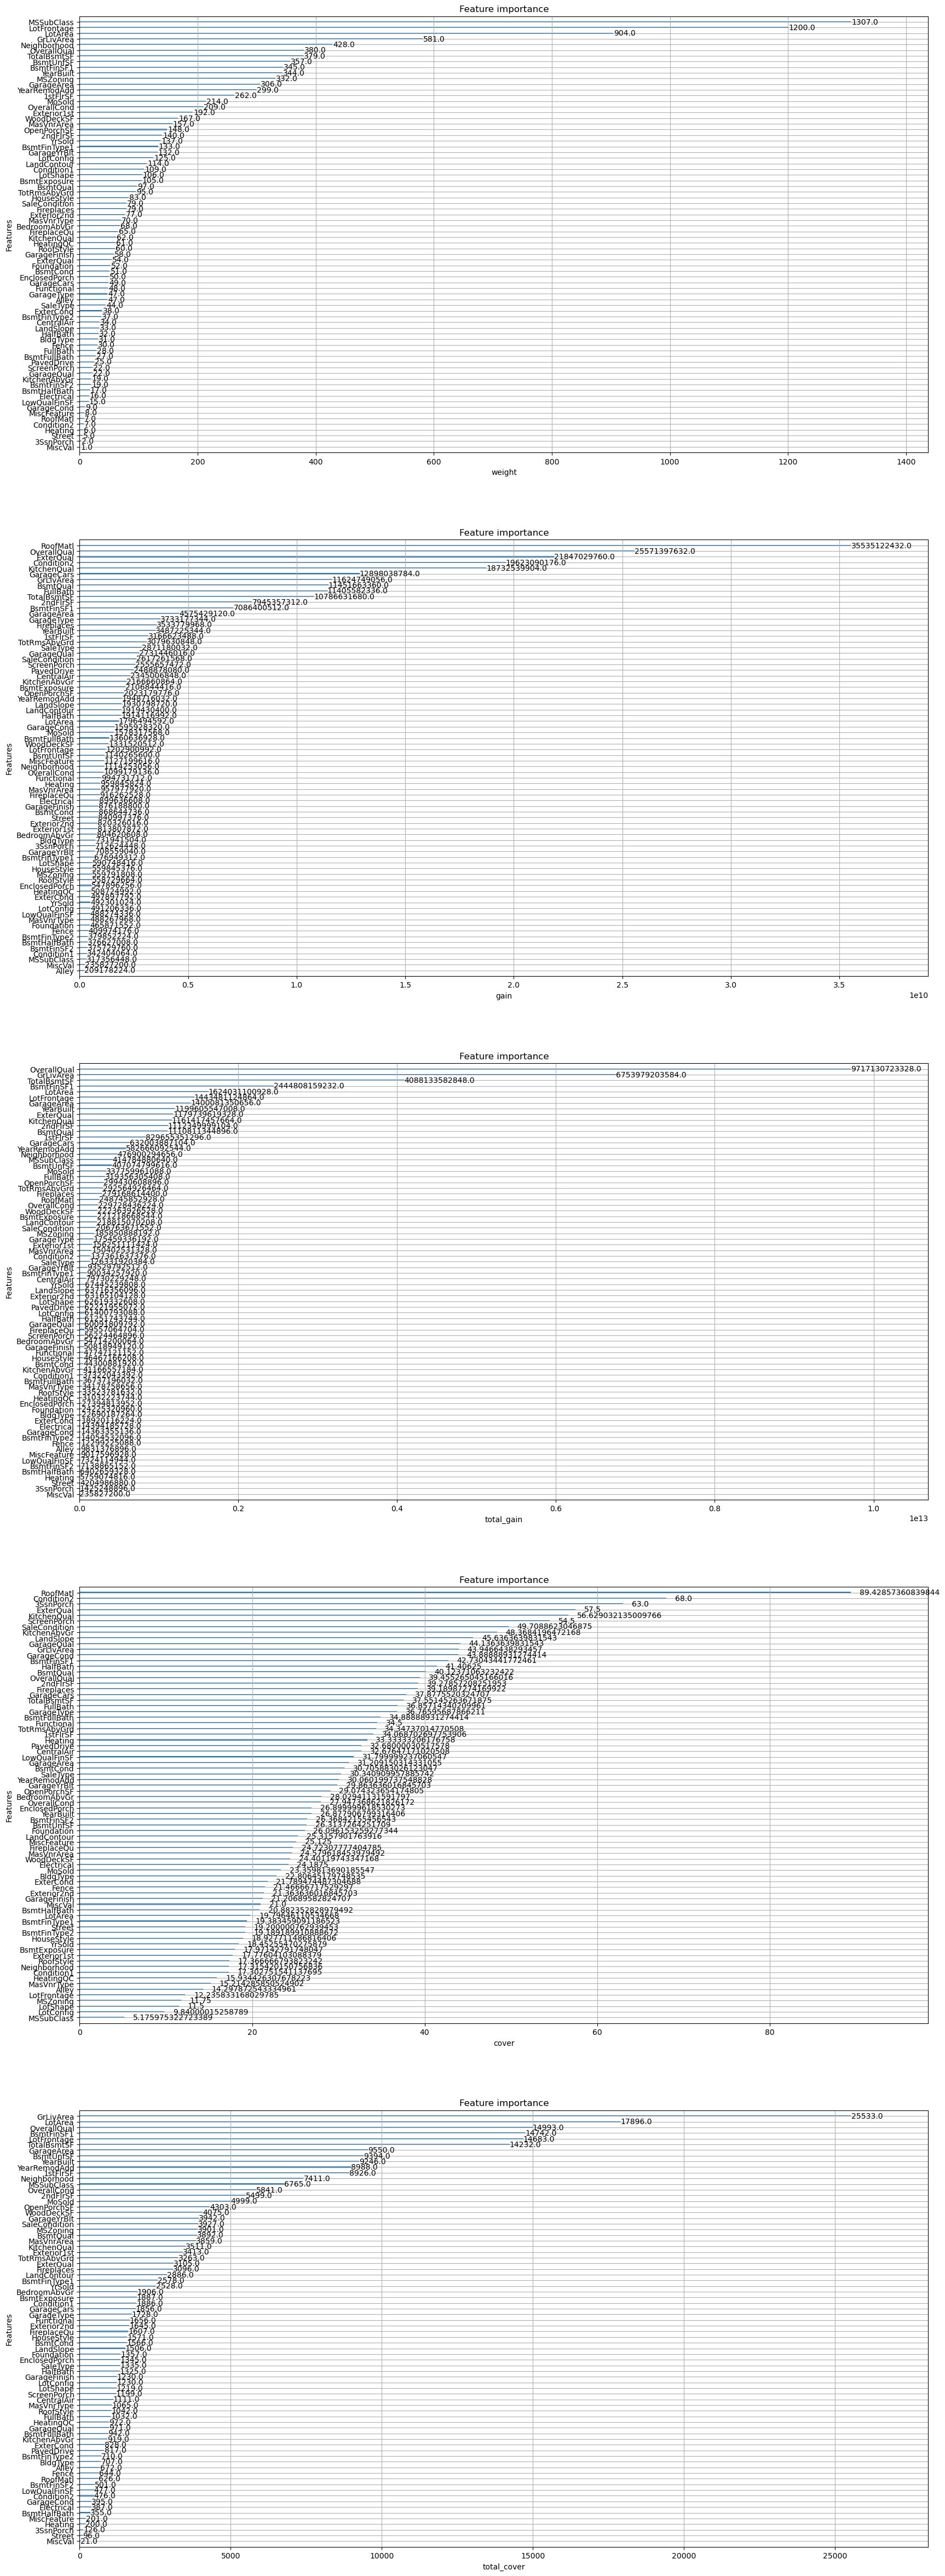

In [9]:
#Display Gradient Boosted Tree's ranking of the top/most relevant input features
# feature_names = X_DATA.columns.values
import matplotlib.pyplot as plt
%matplotlib inline

#Make subplot of weight, total gain, total cover, gain, and cover
plots = ["weight", "gain", "total_gain", "cover", "total_cover"]
fig, ax = plt.subplots(5, 1, figsize = (20, 60))
for plot_num, plot in enumerate(plots):
    xgb.plot_importance(booster = HOUSING_REGRESSOR, ax = ax[plot_num],importance_type = plot, xlabel = plot)
# plt.rcParams['figure.figsize'] = [30, 15]
plt.show()

In [10]:
print(feature_names[70], feature_names[55], feature_names[49], feature_names[46], feature_names[8])

PoolArea Fireplaces HalfBath BsmtFullBath


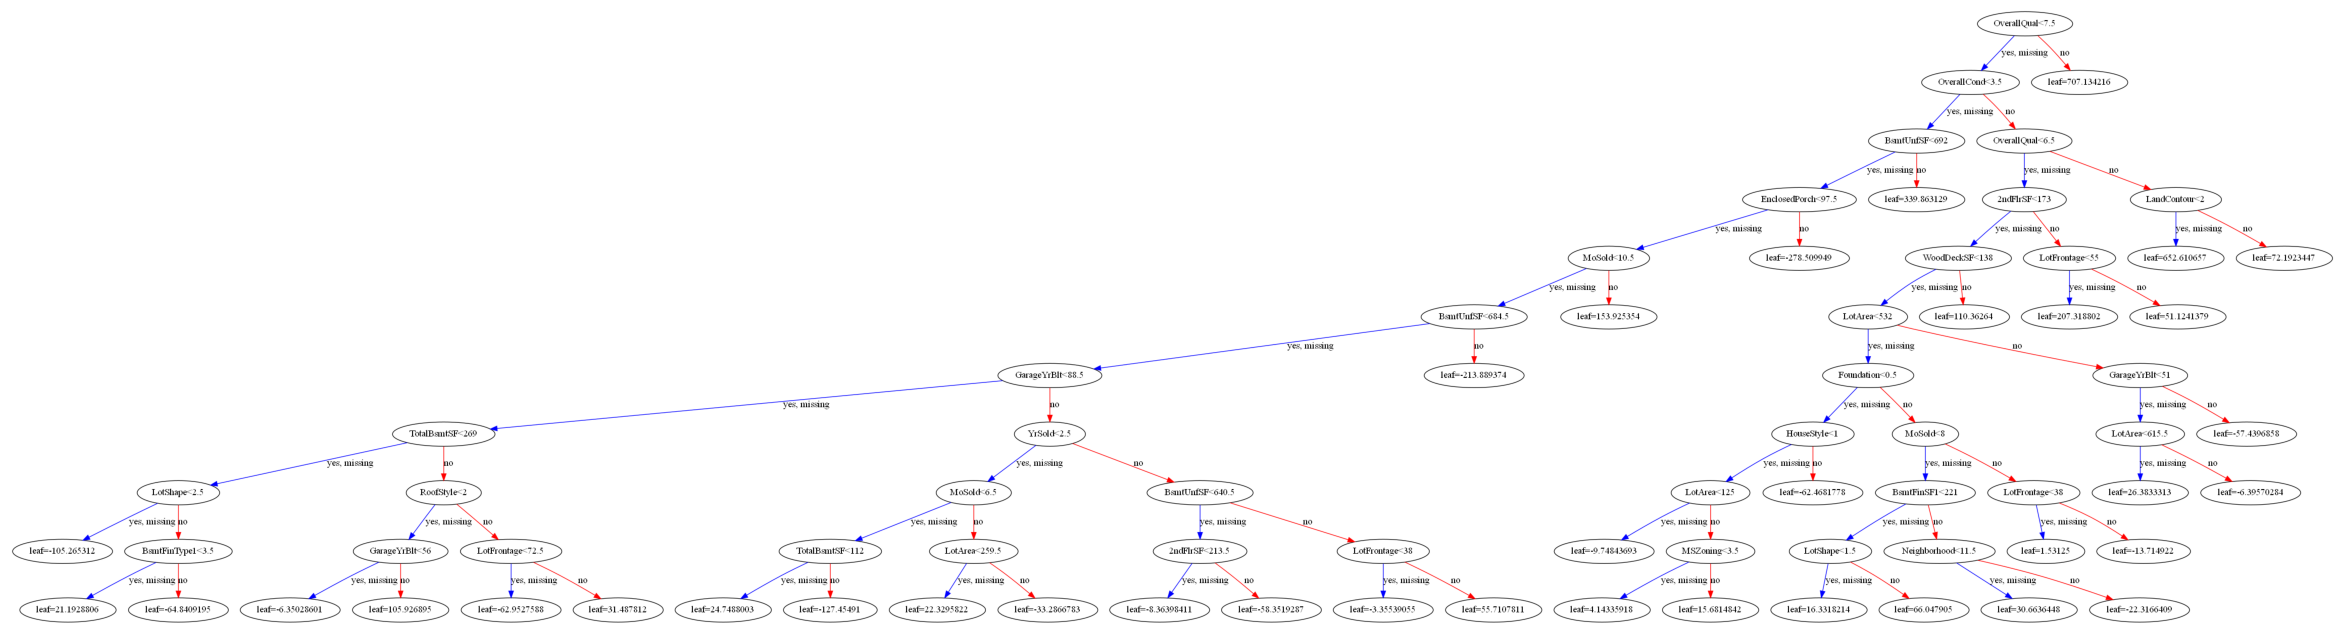

In [65]:
#Plot the first decision tree in the Boosted Tree
import graphviz
import os
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(HOUSING_REGRESSOR, num_trees = 499, ax = ax)
plt.show()

In [ ]:
xgb.plot.multi.trees(HOUSING_REGRESSOR)

In [ ]:

HOUSING_REGRESSOR.predict()